# MNIST 手寫數字辨識 - 純 NumPy CNN 範例（Colab 版）

本 Notebook 示範如何只使用 **Pandas + NumPy**，從頭實作一個簡單的 CNN，來辨識 MNIST 手寫數字（0–9）。

資料格式：
- `mnist_train.csv`：訓練資料，第一欄為 `label`，後面 784 欄為像素值 (0–255)
- `mnist_test.csv`：測試資料，格式相同

接下來每一個區塊都會有中文說明與程式碼註解，方便教學使用。

## 1. 匯入套件

In [3]:
# 匯入必要套件（只使用 pandas 與 numpy）
import pandas as pd
import numpy as np

# 為了結果可重現，設定隨機種子
np.random.seed(42)

## 2. 載入 MNIST 資料集（CSV 版本）

請先在 Colab 左側上傳：
- `mnist_train.csv`
- `mnist_test.csv`

程式假設這兩個檔案與 Notebook 在同一個工作目錄下。

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# 設定檔案路徑（若檔名不同，可在此更改）
train_path = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/Vibe Coding/Data/mnist_test.csv"

# 使用 pandas 讀取 CSV 檔案
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 第 0 欄為標籤 (0~9)，其餘 784 欄為像素值 (0~255)
y_train = train_df.iloc[:, 0].values.astype(np.int64)
X_train = train_df.iloc[:, 1:].values.astype(np.float32) / 255.0  # 正規化到 0~1

y_test = test_df.iloc[:, 0].values.astype(np.int64)
X_test = test_df.iloc[:, 1:].values.astype(np.float32) / 255.0

print("訓練資料：", X_train.shape, y_train.shape)
print("測試資料：", X_test.shape, y_test.shape)

# 將 784 維向量轉為影像 (1, 28, 28)
def flatten_to_image(X_flat):
    """將 (N, 784) 轉為 (N, 1, 28, 28) 影像格式"""
    return X_flat.reshape(-1, 1, 28, 28)

X_train_img = flatten_to_image(X_train)
X_test_img = flatten_to_image(X_test)

print("X_train_img 形狀：", X_train_img.shape)
print("X_test_img 形狀：", X_test_img.shape)

訓練資料： (60000, 784) (60000,)
測試資料： (10000, 784) (10000,)
X_train_img 形狀： (60000, 1, 28, 28)
X_test_img 形狀： (10000, 1, 28, 28)


## 3. 工具函式：One-Hot 編碼、Softmax、損失函數

這裡實作：
- `to_one_hot`：將標籤轉成 one-hot 編碼
- `softmax`：將輸出分數轉為機率
- `compute_loss_and_grad`：計算交叉熵損失與對輸出的梯度

In [6]:
def to_one_hot(y, num_classes=10):
    """將 (N,) 的整數標籤轉成 (N, num_classes) 的 one-hot 矩陣"""
    N = y.shape[0]
    one_hot = np.zeros((N, num_classes), dtype=np.float32)
    one_hot[np.arange(N), y] = 1.0
    return one_hot

def softmax(x):
    """對每一列做 softmax，將分數轉成機率"""
    x_shifted = x - np.max(x, axis=1, keepdims=True)  # 數值穩定
    exp_x = np.exp(x_shifted)
    probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)
    return probs

def compute_loss_and_grad(scores, y_one_hot):
    """計算 softmax + 交叉熵損失及梯度

    scores: (N, num_classes) 模型輸出（未經 softmax）
    y_one_hot: (N, num_classes) 真實標籤 one-hot
    """
    probs = softmax(scores)
    N = scores.shape[0]

    # 交叉熵損失 (cross-entropy loss)
    loss = -np.sum(y_one_hot * np.log(probs + 1e-8)) / N

    # softmax + cross entropy 的梯度簡化形式
    dscores = (probs - y_one_hot) / N

    return loss, dscores, probs

## 4. 實作 CNN 各層：Conv2D / ReLU / MaxPool / Flatten / Fully Connected

我們不使用任何深度學習框架，完全用 NumPy 手刻：
- 卷積層 (Conv2D)：`conv_forward` / `conv_backward`
- ReLU 啟動函數：`relu_forward` / `relu_backward`
- 最大池化層 (MaxPool2D)：`maxpool_forward` / `maxpool_backward`
- 全連接層 (Fully Connected)：`fc_forward` / `fc_backward`

In [7]:
# ---------- 4.1 卷積層 (Conv2D) ----------
def conv_forward(x, W, b):
    """卷積層前向傳遞

    x: (N, C, H, W)
    W: (F, C, HH, WW)
    b: (F,)
    使用 stride=1, padding=0 (valid convolution)
    回傳 out: (N, F, H_out, W_out)
    """
    N, C, H, W_in = x.shape
    F, _, HH, WW = W.shape

    H_out = H - HH + 1
    W_out = W_in - WW + 1

    out = np.zeros((N, F, H_out, W_out), dtype=np.float32)

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    region = x[n, :, i:i+HH, j:j+WW]  # (C, HH, WW)
                    out[n, f, i, j] = np.sum(region * W[f]) + b[f]

    return out

def conv_backward(dout, x, W):
    """卷積層反向傳遞

    dout: (N, F, H_out, W_out)
    x: (N, C, H, W)
    W: (F, C, HH, WW)
    回傳 dW, db, dx
    """
    N, C, H, W_in = x.shape
    F, _, HH, WW = W.shape
    _, _, H_out, W_out = dout.shape

    dW = np.zeros_like(W)
    db = np.zeros((F,), dtype=np.float32)
    dx = np.zeros_like(x)

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    db[f] += dout[n, f, i, j]
                    region = x[n, :, i:i+HH, j:j+WW]
                    dW[f] += region * dout[n, f, i, j]
                    dx[n, :, i:i+HH, j:j+WW] += W[f] * dout[n, f, i, j]

    return dW, db, dx

# ---------- 4.2 ReLU ----------
def relu_forward(x):
    """ReLU 前向：負數變 0"""
    return np.maximum(0, x)

def relu_backward(dout, x):
    """ReLU 反向：x <= 0 的地方梯度為 0"""
    dx = dout.copy()
    dx[x <= 0] = 0
    return dx

# ---------- 4.3 最大池化層 MaxPool2D ----------
def maxpool_forward(x, pool_size=2):
    """最大池化前向

    x: (N, F, H, W)
    pool_size: 池化窗口大小 (pool_size x pool_size)
    使用 stride = pool_size (不重疊)
    """
    N, F, H, W_in = x.shape
    H_out = H // pool_size
    W_out = W_in // pool_size

    out = np.zeros((N, F, H_out, W_out), dtype=np.float32)

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * pool_size
                    h_end = h_start + pool_size
                    w_start = j * pool_size
                    w_end = w_start + pool_size
                    region = x[n, f, h_start:h_end, w_start:w_end]
                    out[n, f, i, j] = np.max(region)

    return out

def maxpool_backward(dout, x, pool_size=2):
    """最大池化反向傳遞

    dout: (N, F, H_out, W_out)
    x: (N, F, H, W)
    回傳 dx: 對輸入 x 的梯度
    """
    N, F, H, W_in = x.shape
    H_out = H // pool_size
    W_out = W_in // pool_size

    dx = np.zeros_like(x)

    for n in range(N):
        for f in range(F):
            for i in range(H_out):
                for j in range(W_out):
                    h_start = i * pool_size
                    h_end = h_start + pool_size
                    w_start = j * pool_size
                    w_end = w_start + pool_size

                    region = x[n, f, h_start:h_end, w_start:w_end]
                    max_val = np.max(region)
                    mask = (region == max_val)
                    dx[n, f, h_start:h_end, w_start:w_end] += mask * dout[n, f, i, j]

    return dx

# ---------- 4.4 全連接層 (Fully Connected Layer) ----------
def fc_forward(x, W, b):
    """全連接層前向

    x: (N, D)
    W: (D, K)
    b: (K,)
    """
    return x.dot(W) + b

def fc_backward(dout, x, W):
    """全連接層反向

    dout: (N, K)
    x: (N, D)
    W: (D, K)
    回傳 dW, db, dx
    """
    dW = x.T.dot(dout)           # (D, N) x (N, K) = (D, K)
    db = np.sum(dout, axis=0)    # 對 batch 求和
    dx = dout.dot(W.T)           # (N, K) x (K, D) = (N, D)
    return dW, db, dx

## 5. 建立 CNN 模型參數與超參數

模型架構：
1. 卷積層：`num_filters` 個 3×3 filter
2. ReLU
3. 2×2 最大池化
4. Flatten
5. 全連接層輸出 10 類別

In [15]:
# 設定超參數
num_classes = 10
num_filters = 8      # 卷積核數量
filter_size = 3      # 卷積核大小 3x3
pool_size = 2        # 最大池化 2x2
learning_rate = 0.01
num_epochs = 5
batch_size = 64

# 輸入影像大小
C, H, W_in = 1, 28, 28

# 卷積輸出大小 (valid convolution)
H_conv = H - filter_size + 1   # 28 - 3 + 1 = 26
W_conv = W_in - filter_size + 1

# 池化輸出大小
H_pool = H_conv // pool_size   # 13
W_pool = W_conv // pool_size   # 13

flatten_dim = num_filters * H_pool * W_pool
print("Flatten 後維度：", flatten_dim)

# 初始化權重（使用小的隨機值）
W_conv = 0.1 * np.random.randn(num_filters, C, filter_size, filter_size).astype(np.float32)
b_conv = np.zeros((num_filters,), dtype=np.float32)

W_fc = 0.1 * np.random.randn(flatten_dim, num_classes).astype(np.float32)
b_fc = np.zeros((num_classes,), dtype=np.float32)

Flatten 後維度： 1352


## 6. 定義訓練與評估函式

這裡我們實作：
- `train_cnn`：執行多個 epoch 的訓練
- `predict`：給定影像資料，輸出預測標籤
- `evaluate_accuracy`：計算分類正確率

In [16]:
def predict(X_img):
    """對輸入影像 (N, 1, 28, 28) 做預測，回傳 (N,) 預測標籤"""
    # Conv
    conv_out = conv_forward(X_img, W_conv, b_conv)
    # ReLU
    relu_out = relu_forward(conv_out)
    # MaxPool
    pool_out = maxpool_forward(relu_out, pool_size=pool_size)
    # Flatten
    N = X_img.shape[0]
    flatten = pool_out.reshape(N, -1)
    # Fully connected
    scores = fc_forward(flatten, W_fc, b_fc)
    # Softmax 機率
    probs = softmax(scores)
    preds = np.argmax(probs, axis=1)
    return preds

def evaluate_accuracy(X_img, y_true):
    """計算給定資料集上的分類正確率"""
    preds = predict(X_img)
    acc = np.mean(preds == y_true)
    return acc

def train_cnn(X_train_img, y_train, X_test_img, y_test,
              num_epochs=3, batch_size=64, learning_rate=0.01):
    """訓練簡單 CNN

    X_train_img: (N_train, 1, 28, 28)
    y_train: (N_train,)
    X_test_img, y_test: 用來監控測試正確率
    """
    global W_conv, b_conv, W_fc, b_fc  # 使用外部定義好的權重

    N_train = X_train_img.shape[0]
    num_batches = N_train // batch_size

    for epoch in range(num_epochs):
        # 打亂資料順序
        indices = np.arange(N_train)
        np.random.shuffle(indices)

        epoch_loss = 0.0

        for bi in range(num_batches):
            batch_idx = indices[bi*batch_size:(bi+1)*batch_size]
            X_batch = X_train_img[batch_idx]
            y_batch = y_train[batch_idx]

            y_batch_one_hot = to_one_hot(y_batch, num_classes=num_classes)

            # -------- Forward --------
            conv_out = conv_forward(X_batch, W_conv, b_conv)
            relu_out = relu_forward(conv_out)
            pool_out = maxpool_forward(relu_out, pool_size=pool_size)
            B = X_batch.shape[0]
            flatten = pool_out.reshape(B, -1)
            scores = fc_forward(flatten, W_fc, b_fc)

            loss, dscores, _ = compute_loss_and_grad(scores, y_batch_one_hot)
            epoch_loss += loss

            # -------- Backward --------
            dW_fc, db_fc, dflatten = fc_backward(dscores, flatten, W_fc)
            dpool = dflatten.reshape(pool_out.shape)
            drelu = maxpool_backward(dpool, relu_out, pool_size=pool_size)
            dconv = relu_backward(drelu, conv_out)
            dW_conv, db_conv, dX = conv_backward(dconv, X_batch, W_conv)

            # -------- 更新權重 (梯度下降) --------
            W_fc -= learning_rate * dW_fc
            b_fc -= learning_rate * db_fc
            W_conv -= learning_rate * dW_conv
            b_conv -= learning_rate * db_conv

        # 每個 epoch 結束，計算訓練 / 測試正確率
        train_acc = evaluate_accuracy(X_train_img, y_train)
        test_acc = evaluate_accuracy(X_test_img, y_test)
        print(f"Epoch {epoch+1}/{num_epochs} - 平均 Loss: {epoch_loss / num_batches:.4f} "
              f"- 訓練正確率: {train_acc:.4f} - 測試正確率: {test_acc:.4f}")

## 7. （選擇性）縮小資料量以加速訓練

由於純 NumPy 實作的 CNN 速度較慢，建議先用較少資料做示範：
- 訓練：最多 10000 筆
- 測試：最多 2000 筆

若你的 Colab 執行效能足夠，也可以把 `num_train_samples` / `num_test_samples` 改大或改成全部資料。

In [17]:
# 實際用於訓練／測試的資料筆數（可自行調整）
num_train_samples = min(500, X_train_img.shape[0])
num_test_samples = min(100, X_test_img.shape[0])

X_train_small = X_train_img[:num_train_samples]
y_train_small = y_train[:num_train_samples]

X_test_small = X_test_img[:num_test_samples]
y_test_small = y_test[:num_test_samples]

print("實際用於訓練的資料量：", X_train_small.shape[0])
print("實際用於測試的資料量：", X_test_small.shape[0])

實際用於訓練的資料量： 500
實際用於測試的資料量： 100


## 8. 開始訓練 CNN

執行下列程式碼後，就會開始進行多個 epoch 的訓練，並顯示：
- 每個 epoch 的平均 Loss
- 訓練集正確率
- 測試集正確率

In [18]:
train_cnn(
    X_train_small, y_train_small,
    X_test_small, y_test_small,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
)

final_test_acc = evaluate_accuracy(X_test_small, y_test_small)
print("\n最終測試正確率：", final_test_acc)

Epoch 1/5 - 平均 Loss: 2.3243 - 訓練正確率: 0.1340 - 測試正確率: 0.2000
Epoch 2/5 - 平均 Loss: 2.2934 - 訓練正確率: 0.1600 - 測試正確率: 0.2200
Epoch 3/5 - 平均 Loss: 2.2736 - 訓練正確率: 0.1700 - 測試正確率: 0.2300
Epoch 4/5 - 平均 Loss: 2.2482 - 訓練正確率: 0.1920 - 測試正確率: 0.2300
Epoch 5/5 - 平均 Loss: 2.2308 - 訓練正確率: 0.2040 - 測試正確率: 0.2300

最終測試正確率： 0.23


## 9. 單一測試樣本的預測

我們可以指定一個測試資料的索引，顯示：
- 這張圖片的真實標籤
- 模型預測結果


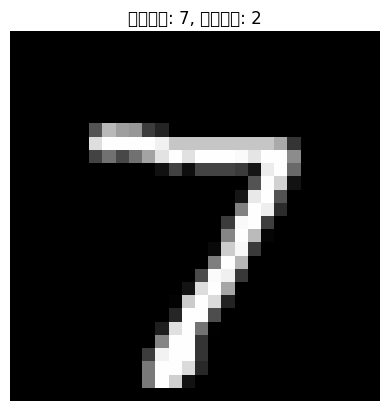

In [19]:
import matplotlib.pyplot as plt

# 指定要查看的測試圖片索引（0 ~ num_test_samples-1）
sample_index = 0

image = X_test_small[sample_index, 0]  # (28, 28)
label_true = y_test_small[sample_index]

# 模型預測
pred_label = predict(X_test_small[sample_index:sample_index+1])[0]

# 顯示影像與標籤
plt.imshow(image, cmap='gray')
plt.title(f"True Label: {label_true}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()